In [788]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from math import isclose

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
# https://stackoverflow.com/questions/57258173/opencv-join-contours-when-rectangle-overlaps-another-rect
# 
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


In [790]:
meter2pixels = 100

In [153]:
!pip install descartes

In [2]:
import shapely

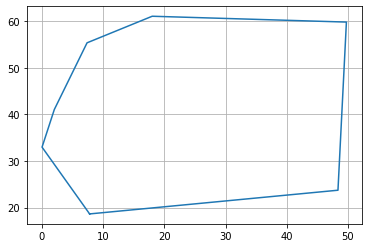

In [4]:
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

def generateConvexPolygon(n):
    MAX_COORD = 50
    pts = MAX_COORD * np.random.rand(n, 2)
    x, y = pts[:,0], pts[:,1]
    x = x[1:] + [x[1]]
    y = y[1:] + [y[1]]
    poly = Polygon(zip(x, y))
    convex_hull_x, convex_hull_y = [z.tolist() for z in poly.convex_hull.exterior.coords.xy]
    return (convex_hull_x, convex_hull_y)
    

def generateRectilinearPolygon(n):
    pass

def drawPolygonByHull(hull_x, hull_y):
    plt.plot(hull_x, hull_y)
    plt.grid(True)
    plt.show()
    
hull_x, hull_y = generateConvexPolygon(25)
drawPolygonByHull(hull_x, hull_y)

noisePoint:  (46.1370051085694, 16.073527948192012)


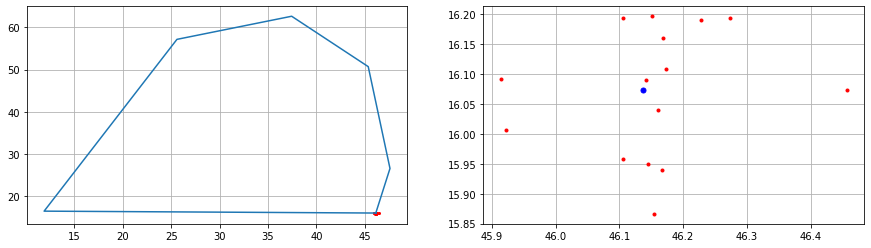

In [549]:
def addNormalNoiseAroundPoint(point, n=5, mu=0.0, sigma=0.1):
    # point is (x, y)    
    x_noise = point[0] + np.random.normal(mu, sigma, n)
    y_noise = point[1] + np.random.normal(mu, sigma, n)
    return x_noise, y_noise

hull_x, hull_y = generateConvexPolygon(10)

noisePoint = (hull_x[0], hull_y[0])
print('noisePoint: ', noisePoint)


noise_x, noise_y = addNormalNoiseAroundPoint(noisePoint, n=15,  mu=0, sigma=0.1)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(noise_x, noise_y, 'ro', c='red', alpha=1, markersize=2)
ax[0].plot(hull_x, hull_y)
ax[0].grid(True)


ax[1].plot(noise_x, noise_y, 'ro', c='red', alpha=1, markersize=3)
ax[1].plot(noisePoint[0], noisePoint[1], 'ro', c='blue', alpha=1, markersize=5)
ax[1].grid(True)

plt.show()

(82.89970377541438, 30.354777206473788) (45.534269347761736, 52.29698249972881)


/home/yaroslav/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


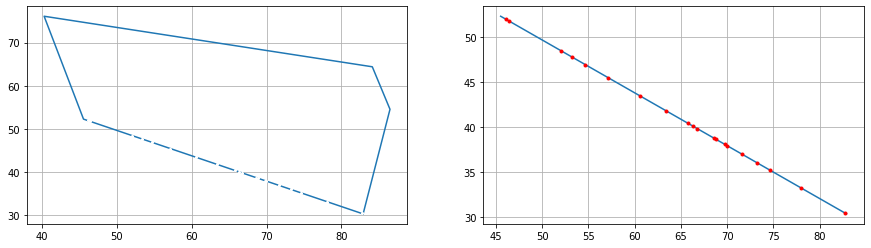

In [254]:
from scipy.stats import uniform
from numpy import ones,vstack
from numpy.linalg import lstsq

def getRandomPointsOnEdge(p1, p2, n=20):
    # delete n random points on edge by uniform distribution
    
    def y(x, m, c):
        return m * x + c
    
    points = [p1, p2]
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]
    # Line Solution is y = mx + c
    if isclose(abs(p1[0] - p2[0]), 0, abs_tol=0.00001):
        yMax, yMin = max(p1[1], p2[1]), min(p1[1], p2[1])
        L = yMax - yMin
        y_delete = yMin + L * np.random.rand(n)
        x_delete = [p1[0]] * n
    else:
        xMax, xMin = max(p1[0], p2[0]), min(p1[0], p2[0])
        L = xMax - xMin
        x_delete = xMin + L * np.random.rand(n)
        y_delete = np.array([y(x, m, c) for x in x_delete])
    
    return (x_delete, y_delete)

p1 = (hull_x[0], hull_y[0])
p2 = (hull_x[1], hull_y[1])

print(p1, p2)
x_delete, y_delete = getRandomPointsOnEdge(p1, p2)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# ax[0].plot(noise_x, noise_y, 'ro', c='red', alpha=1, markersize=2)
ax[0].plot(hull_x, hull_y)
ax[0].plot(x_delete, y_delete, 'ro', c='white', alpha=1, markersize=2)
ax[0].grid(True)


ax[1].plot([p1[0], p2[0]], [p1[1], p2[1]], alpha=1, markersize=3)
ax[1].plot(x_delete, y_delete, 'ro', c='red', alpha=1, markersize=3)
# ax[1].plot(noisePoint[0], noisePoint[1], 'ro', c='blue', alpha=1, markersize=5)
ax[1].grid(True)

plt.show()

In [15]:
!wget https://raw.githubusercontent.com/stepmat/rectilinear_polygon_generator/master/blank.png

--2020-05-25 12:57:21--  https://raw.githubusercontent.com/stepmat/rectilinear_polygon_generator/master/blank.png
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 151.101.244.133
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 20069 (20K) [image/png]
Сохранение в: «blank.png»

blank.png           100%[===================>]  19,60K  --.-KB/s    за 0,03s   

2020-05-25 12:57:21 (769 KB/s) - «blank.png» сохранён [20069/20069]



In [792]:
# https://github.com/stepmat/rectilinear_polygon_generator/blob/master/generate_polygon.py

import sys
import cv2
import numpy
import copy
import scipy.misc
import itertools
from PIL import Image, ImageOps, ImageDraw
from scipy.ndimage import morphology, label
from copy import deepcopy
from operator import itemgetter
from statistics import median, mean
from math import sqrt
from random import randint


def generateRectilinearPolygon(num_rect = 3,
                               canvas_shapes = (20, 20),
                               min_size = 1,
                               max_size = 5,
                               increments = 100,
                               area_m2 = 1000):
#     num_rect = randint(5, 15) # rect. .nums
    canvas_width, canvas_height = canvas_shapes[1], canvas_shapes[0]
    img = np.zeros([increments*canvas_height,increments*canvas_width,3],dtype=np.uint8)
    img.fill(255)
    img = Image.fromarray(img)
    img = ImageOps.grayscale(img)
    im = np.array(img)
    
    im = morphology.grey_dilation(im, (3, 3)) - im      # inner morphological gradient
    img = Image.fromarray(im)
    visual = img.convert('RGB')
    draw = ImageDraw.Draw(visual)

    # Generate random number of rectangles (must be touching) of random sizes
    boxes = []
    for i in range(num_rect):
        valid = 0
        while(valid == 0):
            width = randint(min_size, max_size)*increments
            height = randint(min_size, max_size)*increments
            pos_x = randint(max_size+1, canvas_width-max_size-1)*increments
            pos_y = randint(max_size+1, canvas_height-max_size-1)*increments
            for j in boxes:
                touching = 1
                if (pos_x+(width/2.0) < j[0]-(j[2]/2.0)):
                    touching = 0
                if (pos_x-(width/2.0) > j[0]+(j[2]/2.0)):
                    touching = 0
                if (pos_y+(height/2.0) < j[1]-(j[3]/2.0)):
                    touching = 0
                if (pos_y-(height/2.0) > j[1]+(j[3]/2.0)):
                    touching = 0
                if touching == 1:
                    valid = 1
            if len(boxes) == 0:
                valid = 1
        boxes.append([pos_x,pos_y,width,height])
    # for i in boxes:
    #     print(i)
    # print('******************')


    # Extend those that stick out to the ground
    bottom_ground = 0
    for i in boxes:
        if (i[1] + (i[3]/2.0)) > bottom_ground:
            bottom_ground = (i[1] + (i[3]/2.0))

    for i in range(len(boxes)):
        bottom_left = [boxes[i][0]-(boxes[i][2]/2.0),boxes[i][1]+(boxes[i][3]/2.0)]
        bottom_right = [boxes[i][0]+(boxes[i][2]/2.0),boxes[i][1]+(boxes[i][3]/2.0)]
        line_check = [bottom_left,bottom_right]
        intersect = 0
        for j in range(len(boxes)):
            if i!=j:
                p1 = [boxes[j][0]-(boxes[j][2]/2.0),boxes[j][1]-(boxes[j][3]/2.0)-1]
                p2 = [boxes[j][0]-(boxes[j][2]/2.0),boxes[j][1]+(boxes[j][3]/2.0)+1]
                p3 = [boxes[j][0]+(boxes[j][2]/2.0),boxes[j][1]-(boxes[j][3]/2.0)-1]
                p4 = [boxes[j][0]+(boxes[j][2]/2.0),boxes[j][1]+(boxes[j][3]/2.0)+1]
                line_check2 = [p1,p2]
                line_check3 = [p3,p4]
                if (line_check[0][0] < line_check2[0][0]) and (line_check[1][0] > line_check2[0][0]):
                    if (line_check[0][1] > line_check2[0][1]) and (line_check[0][1] < line_check2[1][1]):
                        intersect = 1
                if (line_check[0][0] < line_check3[0][0]) and (line_check[1][0] > line_check3[0][0]):
                    if (line_check[0][1] > line_check3[0][1]) and (line_check[0][1] < line_check3[1][1]):
                        intersect = 1
                if (line_check[0][0] > line_check2[0][0]) and (line_check[1][0] > line_check2[0][0]):
                    if (line_check[0][0] < line_check3[0][0]) and (line_check[1][0] < line_check3[0][0]):
                        if (line_check[0][1] > line_check2[0][1]) and (line_check[0][1] < line_check2[1][1]):
                            intersect = 1
        if intersect == 0:
            current_bottom = boxes[i][1] + (boxes[i][3]/2.0)
            to_add = bottom_ground-current_bottom
            boxes[i][3] = boxes[i][3] + to_add
            boxes[i][1] = boxes[i][1] + (to_add/2.0)

    # Draw resulting rectangles as image
    tlbr = []
    for i in boxes:
        top_left = (i[0]-(i[2]/2.0),i[1]-(i[3]/2.0))
        bottom_right = (i[0]+(i[2]/2.0),i[1]+(i[3]/2.0))
        tlbr.append((top_left, bottom_right))
        draw.rectangle((top_left,bottom_right), fill='white')
    
    img = np.array(visual.convert('L'))
#     img = cv2.imread('output.jpg',0)
    ret,thresh = cv2.threshold(img,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2) 
    cnt = contours[0]
    M = cv2.moments(cnt)

    epsilon = 0.001 * cv2.arcLength(cnt,True)
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    poly_x = approx[:, :, 0]
    poly_x = np.append(poly_x, approx[:, :, 0][0])
    poly_y = approx[:, :, 1]
    poly_y = np.append(poly_y, approx[:, :, 1][0])
    
    polygon = Polygon([(p[0],p[1]) for p in zip(poly_x, poly_y)])
    polygonArea = polygon.area # in pix^2
    polygonArea /= meter2pixels**2 # in metres
    
    proportion = area_m2 / polygonArea
    proportion_side = np.sqrt(proportion)
    
    return proportion_side * poly_x, proportion_side * poly_y


generateRectilinearPolygon(randint(5, 15))

(array([7221.62510933, 4731.40955439, 4726.42912328, 3486.30177692,
        3481.32134581, 1743.15088846, 1743.15088846, 3481.32134581,
        3486.30177692, 4233.3664434 , 4233.3664434 , 4731.40955439,
        4731.40955439, 5727.49577637, 5727.49577637, 5483.45465198,
        5478.47422087, 7221.62510933, 7221.62510933]),
 array([2241.19399945, 2241.19399945, 3486.30177692, 3486.30177692,
        4233.3664434 , 4233.3664434 , 4731.40955439, 4731.40955439,
        5478.47422087, 5483.45465198, 6972.60355384, 6972.60355384,
        5981.49776297, 5976.51733186, 3984.34488791, 3984.34488791,
        3740.30376352, 3735.32333241, 2241.19399945]))

In [168]:
# import matplotlib 
# import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = fig.add_subplot(111)

# for rect in tlbr:
#     tl = rect[0]
#     br = rect[1]
#     h = br[1] - tl[1]
#     w = br[0] - tl[0]
#     rect = matplotlib.patches.Rectangle(tl, w, h, fill=False, edgecolor='navy', linewidth=3)
#     ax.add_patch(rect)

# plt.xlim([0, 2500])
# plt.ylim([0, 2500])
# plt.grid()
# plt.show() 

# def unzipTlbrRectangle(rect):
#     x1, y1, x2, y2 = rect[0][0], rect[0][1], rect[1][0], rect[1][1]
#     return (x1, y1, x2, y2)

# def checkIntersectionRectangles(rect1, rect2):
#     x1, y1, x2, y2 = unzipTlbrRectangle(rect1)
#     x3, y3, x4, y4 = unzipTlbrRectangle(rect2)
#     return not (x2 < x3 or x1 > x4 or y2 < y3 or y1 > y4)

# def checkLineOnEdge(line, edge):
#     pass

# def getIntersectionPointRectangles(rect1, rect2):    
# #     if checkIntersectionRectangles(rect1, rect2):
# #         return None
    
#     x1, y1, x2, y2 = unzipTlbrRectangle(rect1)
#     x3, y3, x4, y4 = unzipTlbrRectangle(rect2)
    
#     x5 = max(x1, x3)
#     y5 = max(y1, y3)
#     x6 = min(x2, x4)
#     y6 = min(y2, y4)

#     return [(x5, y5), (x6, y6)]

# def tlbr2points(tlbr):
#     tl, br = tlbr[0], tlbr[1]
#     h = br[1] - tl[1]
#     w = br[0] - tl[0]
#     return [list(tl), [tl[0], tl[1] + h], [tl[0] + w, tl[1] + h], [tl[0] + w, tl[1]]]

# fig = plt.figure()
# ax = fig.add_subplot(111)

# for rect in tlbr:
#     tl = rect[0]
#     br = rect[1]
#     h = br[1] - tl[1]
#     w = br[0] - tl[0]
#     rect = matplotlib.patches.Rectangle(tl, w, h, fill=False, edgecolor='navy', linewidth=3)
#     ax.add_patch(rect)

    
# for i in range(len(tlbr) - 1):
#     for j in range(i+1, len(tlbr)):
#         rectInter = getIntersectionPointRectangles(tlbr[i], tlbr[j])
# #         if rectInter is None:
# #             continue
#         tl = rectInter[0]
#         br = rectInter[1]
#         h = br[1] - tl[1]
#         w = br[0] - tl[0]
#         rect = matplotlib.patches.Rectangle(tl, w, h, fill=False, edgecolor='red', linewidth=3)
#         ax.add_patch(rect)
        
# plt.xlim([0, 2500])
# plt.ylim([0, 2500])
# plt.grid()
# plt.show() 

## Find polygon contour from image

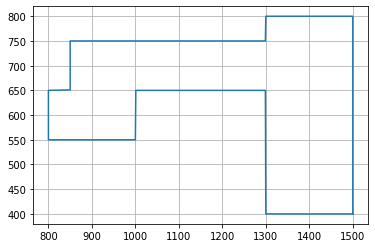

In [187]:
import cv2
import numpy as np
 
poly_x, poly_y = generateRectilinearPolygon()
drawPolygonByHull(poly_x, poly_y)

eps= 0.6191313708305359


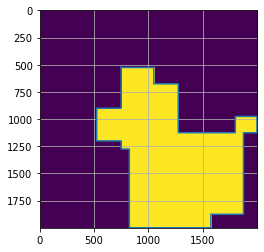

In [345]:
# ex 1

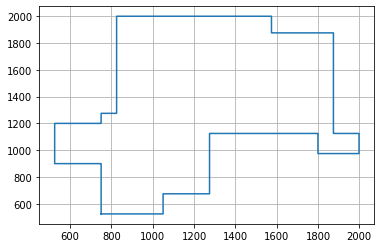

In [346]:
# ex 2

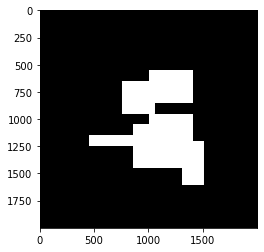

In [369]:
img = np.array(Image.open('output.jpg'))
plt.imshow(img)
plt.show()

eps= 53.94727921843529


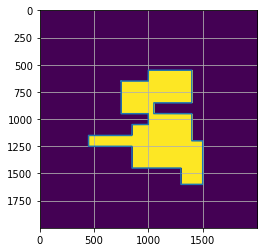

In [362]:
# ex 3

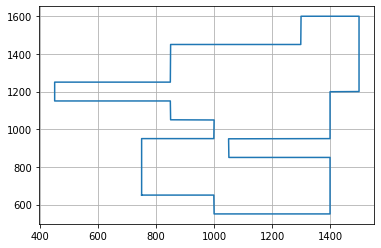

In [364]:
# ex 3

## Generating contours

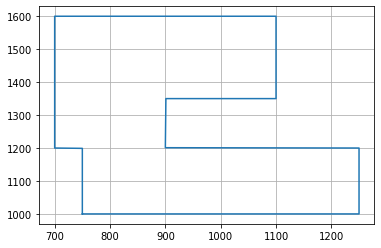

In [193]:
poly_x, poly_y = generateRectilinearPolygon()
drawPolygonByHull(poly_x, poly_y)

In [266]:
def getLengthOfLine(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def makeEdgeBold(p1, p2):
    pass

Num delete points: 86
Num noise points: 960


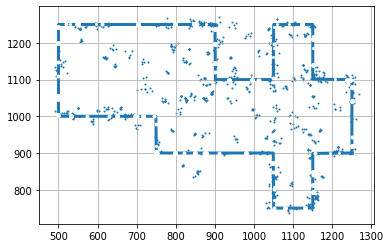

In [556]:
#### TODO:
# 1. random delete and random noise INC for each edge
# 2. add noise into polygon
# 3. different size of markersize in scatter 
# 4. make some edges bold
# 5. add gap in vertex

DELETE_INC = 30
NOISE_INC = 40
NOISE_INC_INNER = 80
PROB_TAKE_INNER_LINE = 0.2
N = len(poly_x)

x_del = np.array([])
y_del = np.array([])
for i in range(N - 1):
    p1, p2 = (poly_x[i], poly_y[i]), (poly_x[i+1], poly_y[i+1])
    lengthLine = getLengthOfLine(p1, p2)
    numDelete = int(lengthLine // DELETE_INC)
    x_delCur, y_delCur = getRandomPointsOnEdge(p1, p2, n=numDelete)
    x_del = np.concatenate((x_del, x_delCur))
    y_del = np.concatenate((y_del, y_delCur))

x_noise = np.array([])
y_noise = np.array([])

for i in range(N - 1):
    # for neighbor vertex
    p1, p2 = (poly_x[i], poly_y[i]), (poly_x[i+1], poly_y[i+1])
    lengthLine = getLengthOfLine(p1, p2)
    numNoise = int(lengthLine // NOISE_INC)
    x_noiseCur, y_noiseCur = getRandomPointsOnEdge(p1, p2, n=numNoise)
    for j in range(len(x_noiseCur)):
        curPoint = (x_noiseCur[j], y_noiseCur[j])
        sigmaCoef = np.random.randint(10)
        x_curNoisePoints, y_curNoisePoints = addNormalNoiseAroundPoint(curPoint, n=5, mu=0.0, sigma=sigmaCoef)
        x_noise = np.concatenate((x_noise, x_curNoisePoints))
        y_noise = np.concatenate((y_noise, y_curNoisePoints))

innerEdgeProbs = np.random.rand(N * (N-1) // 2)
takeEdge = innerEdgeProbs > PROB_INNER_LINE_TRESH
for i in range(N-1):
    for j in range(i+1, N):
        lineProb = np.random.rand()
        if lineProb < PROB_TAKE_INNER_LINE:
            p1, p2 = (poly_x[i], poly_y[i]), (poly_x[j], poly_y[j])
            lengthLine = getLengthOfLine(p1, p2)
            numNoise = int(lengthLine // NOISE_INC_INNER)
            x_noiseCur, y_noiseCur = getRandomPointsOnEdge(p1, p2, n=numNoise)
            for j in range(len(x_noiseCur)):
                curPoint = (x_noiseCur[j], y_noiseCur[j])
                sigmaCoef = np.random.randint(10)
                x_curNoisePoints, y_curNoisePoints = addNormalNoiseAroundPoint(curPoint, n=5, mu=0.0, sigma=sigmaCoef)
                x_noise = np.concatenate((x_noise, x_curNoisePoints))
                y_noise = np.concatenate((y_noise, y_curNoisePoints))
        
print('Num delete points:',len(x_del))
print('Num noise points:',len(x_noise))


plt.plot(poly_x, poly_y, linewidth=3)
plt.scatter(x_noise, y_noise, s=1)
plt.hexbin(x,y)
for i in range(len(x_del)):
    curMarkerSize = 1 + np.random.randint(1, 4)
    plt.plot(x_del[i], y_del[i], 'ro', c='white', alpha=1, markersize=curMarkerSize)
plt.grid(True)

plt.show()

/home/yaroslav/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


Num delete points: 81
Num noise points: 670


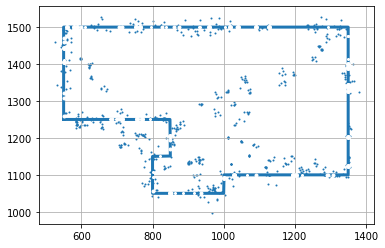

/home/yaroslav/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


Num delete points: 93
Num noise points: 765


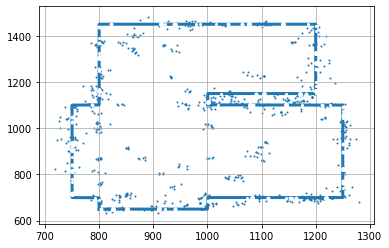

/home/yaroslav/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


Num delete points: 86
Num noise points: 725


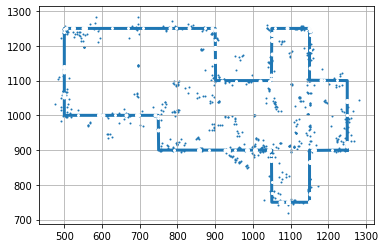

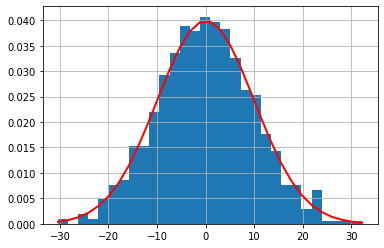

In [495]:
# рассморим добавление 
mu, sigma = 0, 10# mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

count, bins, ignored = plt.hist(s, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.grid(True)
plt.show()

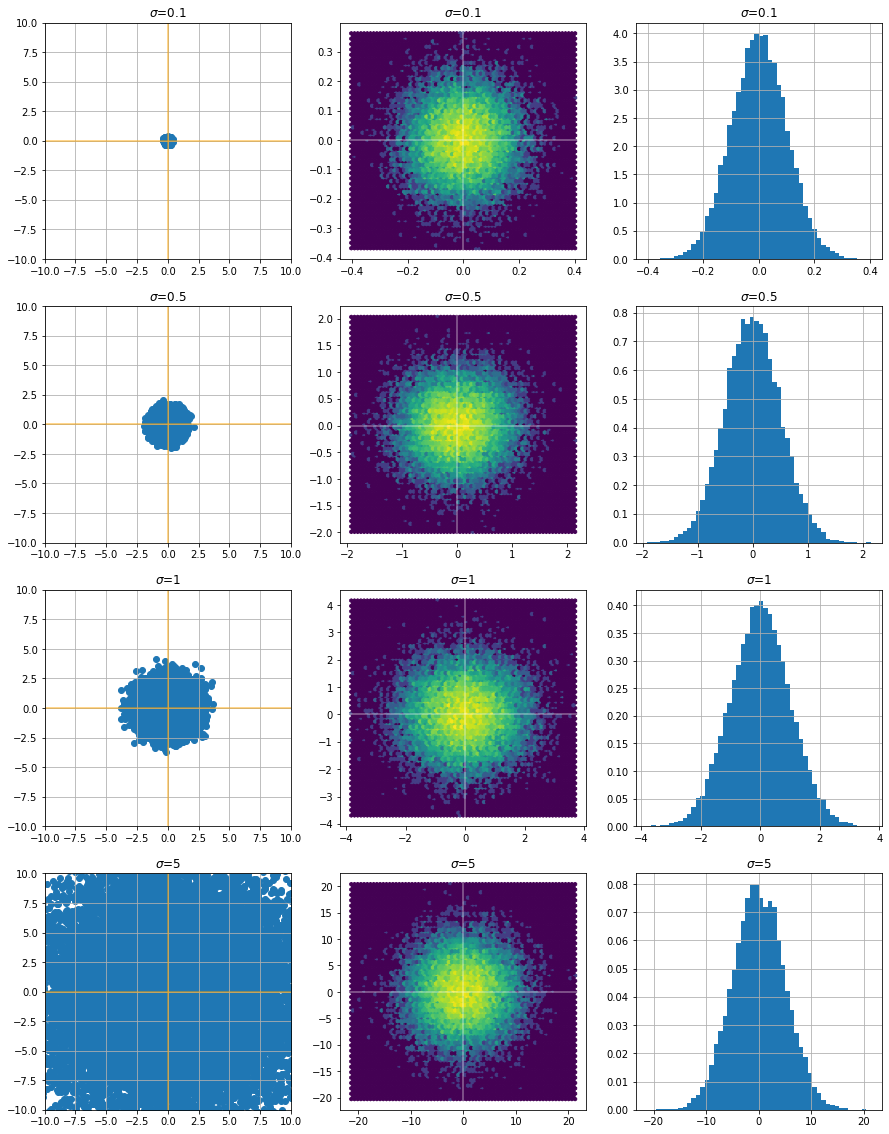

In [647]:
# check noise 
sigmaCoefs = [0.1, 0.5, 1, 5]
fig, ax = plt.subplots(len(sigmaCoefs), 3,  figsize=(15, 20))
startPoint = (0, 0)
for i, sc in enumerate(sigmaCoefs):
    x_noise, y_noise = addNormalNoiseAroundPoint(startPoint, n=20000, mu=0, sigma=sc)
    
    ax[i][0].axhline(0, color='orange', alpha=0.6)
    ax[i][0].axvline(0, color='orange', alpha=0.6)
    ax[i][0].scatter(x_noise, y_noise)
    ax[i][0].grid(True)
    ax[i][0].set_ylim(-10, 10)
    ax[i][0].set_xlim(-10, 10)
    ax[i][0].set_title('$\sigma$=' + str(sc))
    
    ax[i][1].hexbin(x_noise, y_noise, gridsize=70, bins='log')
    ax[i][1].axhline(0, color='white', alpha=0.4)
    ax[i][1].axvline(0, color='white', alpha=0.4)
    ax[i][1].set_title('$\sigma$=' + str(sc))
    
    
    ax[i][2].hist(x_noise, 50, density=True)
    ax[i][2].grid(True)
    ax[i][2].set_title('$\sigma$=' + str(sc))    

Polygon contains (0.5, 0.25):  True
Polygon contains (0.5, 1):  False
0.2


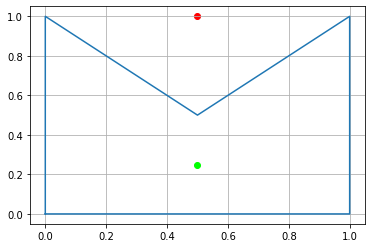

In [724]:

point = Point(0.5, 0.2)
polygon = Polygon([(0, 0), (0, 1), (0.5, 0.5), (1, 1), (1, 0)])

print('Polygon contains (0.5, 0.25): ', polygon.contains(Point(0.5, 0.25)))
print('Polygon contains (0.5, 1): ', polygon.contains(Point(0.5, 1)))
print(polygon.exterior.distance(point))
x,y = polygon.exterior.xy
plt.scatter(0.5, 0.25, c='lime')
plt.scatter(0.5, 1, c='r')
plt.plot(x,y)
plt.grid(True)
plt.show()

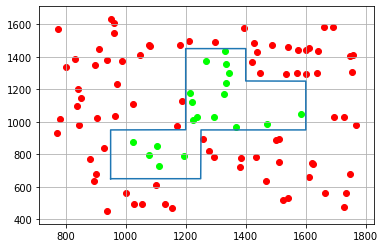

In [720]:
poly_x, poly_y = generateRectilinearPolygon()
polygon = Polygon([(p[0], p[1]) for p in zip(poly_x, poly_y)])

random_x = np.random.uniform(np.min(polygon.exterior.xy[0]) - 200, np.max(polygon.exterior.xy[0]) + 200, 100)
random_y = np.random.uniform(np.min(polygon.exterior.xy[1]) - 200, np.max(polygon.exterior.xy[1]) + 200, 100)
points = [Point(p[0], p[1]) for p in zip(random_x, random_y)]

for i in range(len(points)):
    plt.scatter(points[i].x, points[i].y, c= 'lime' if polygon.contains(points[i]) else 'r')

x,y = polygon.exterior.xy
plt.plot(x,y)
plt.grid(True)
plt.show()

In [777]:
poly_x, poly_y = generateRectilinearPolygon(area_m2=1000)

S(polygon)= 10000000.0 px
S(polygon)= 1000.0 m2
5000


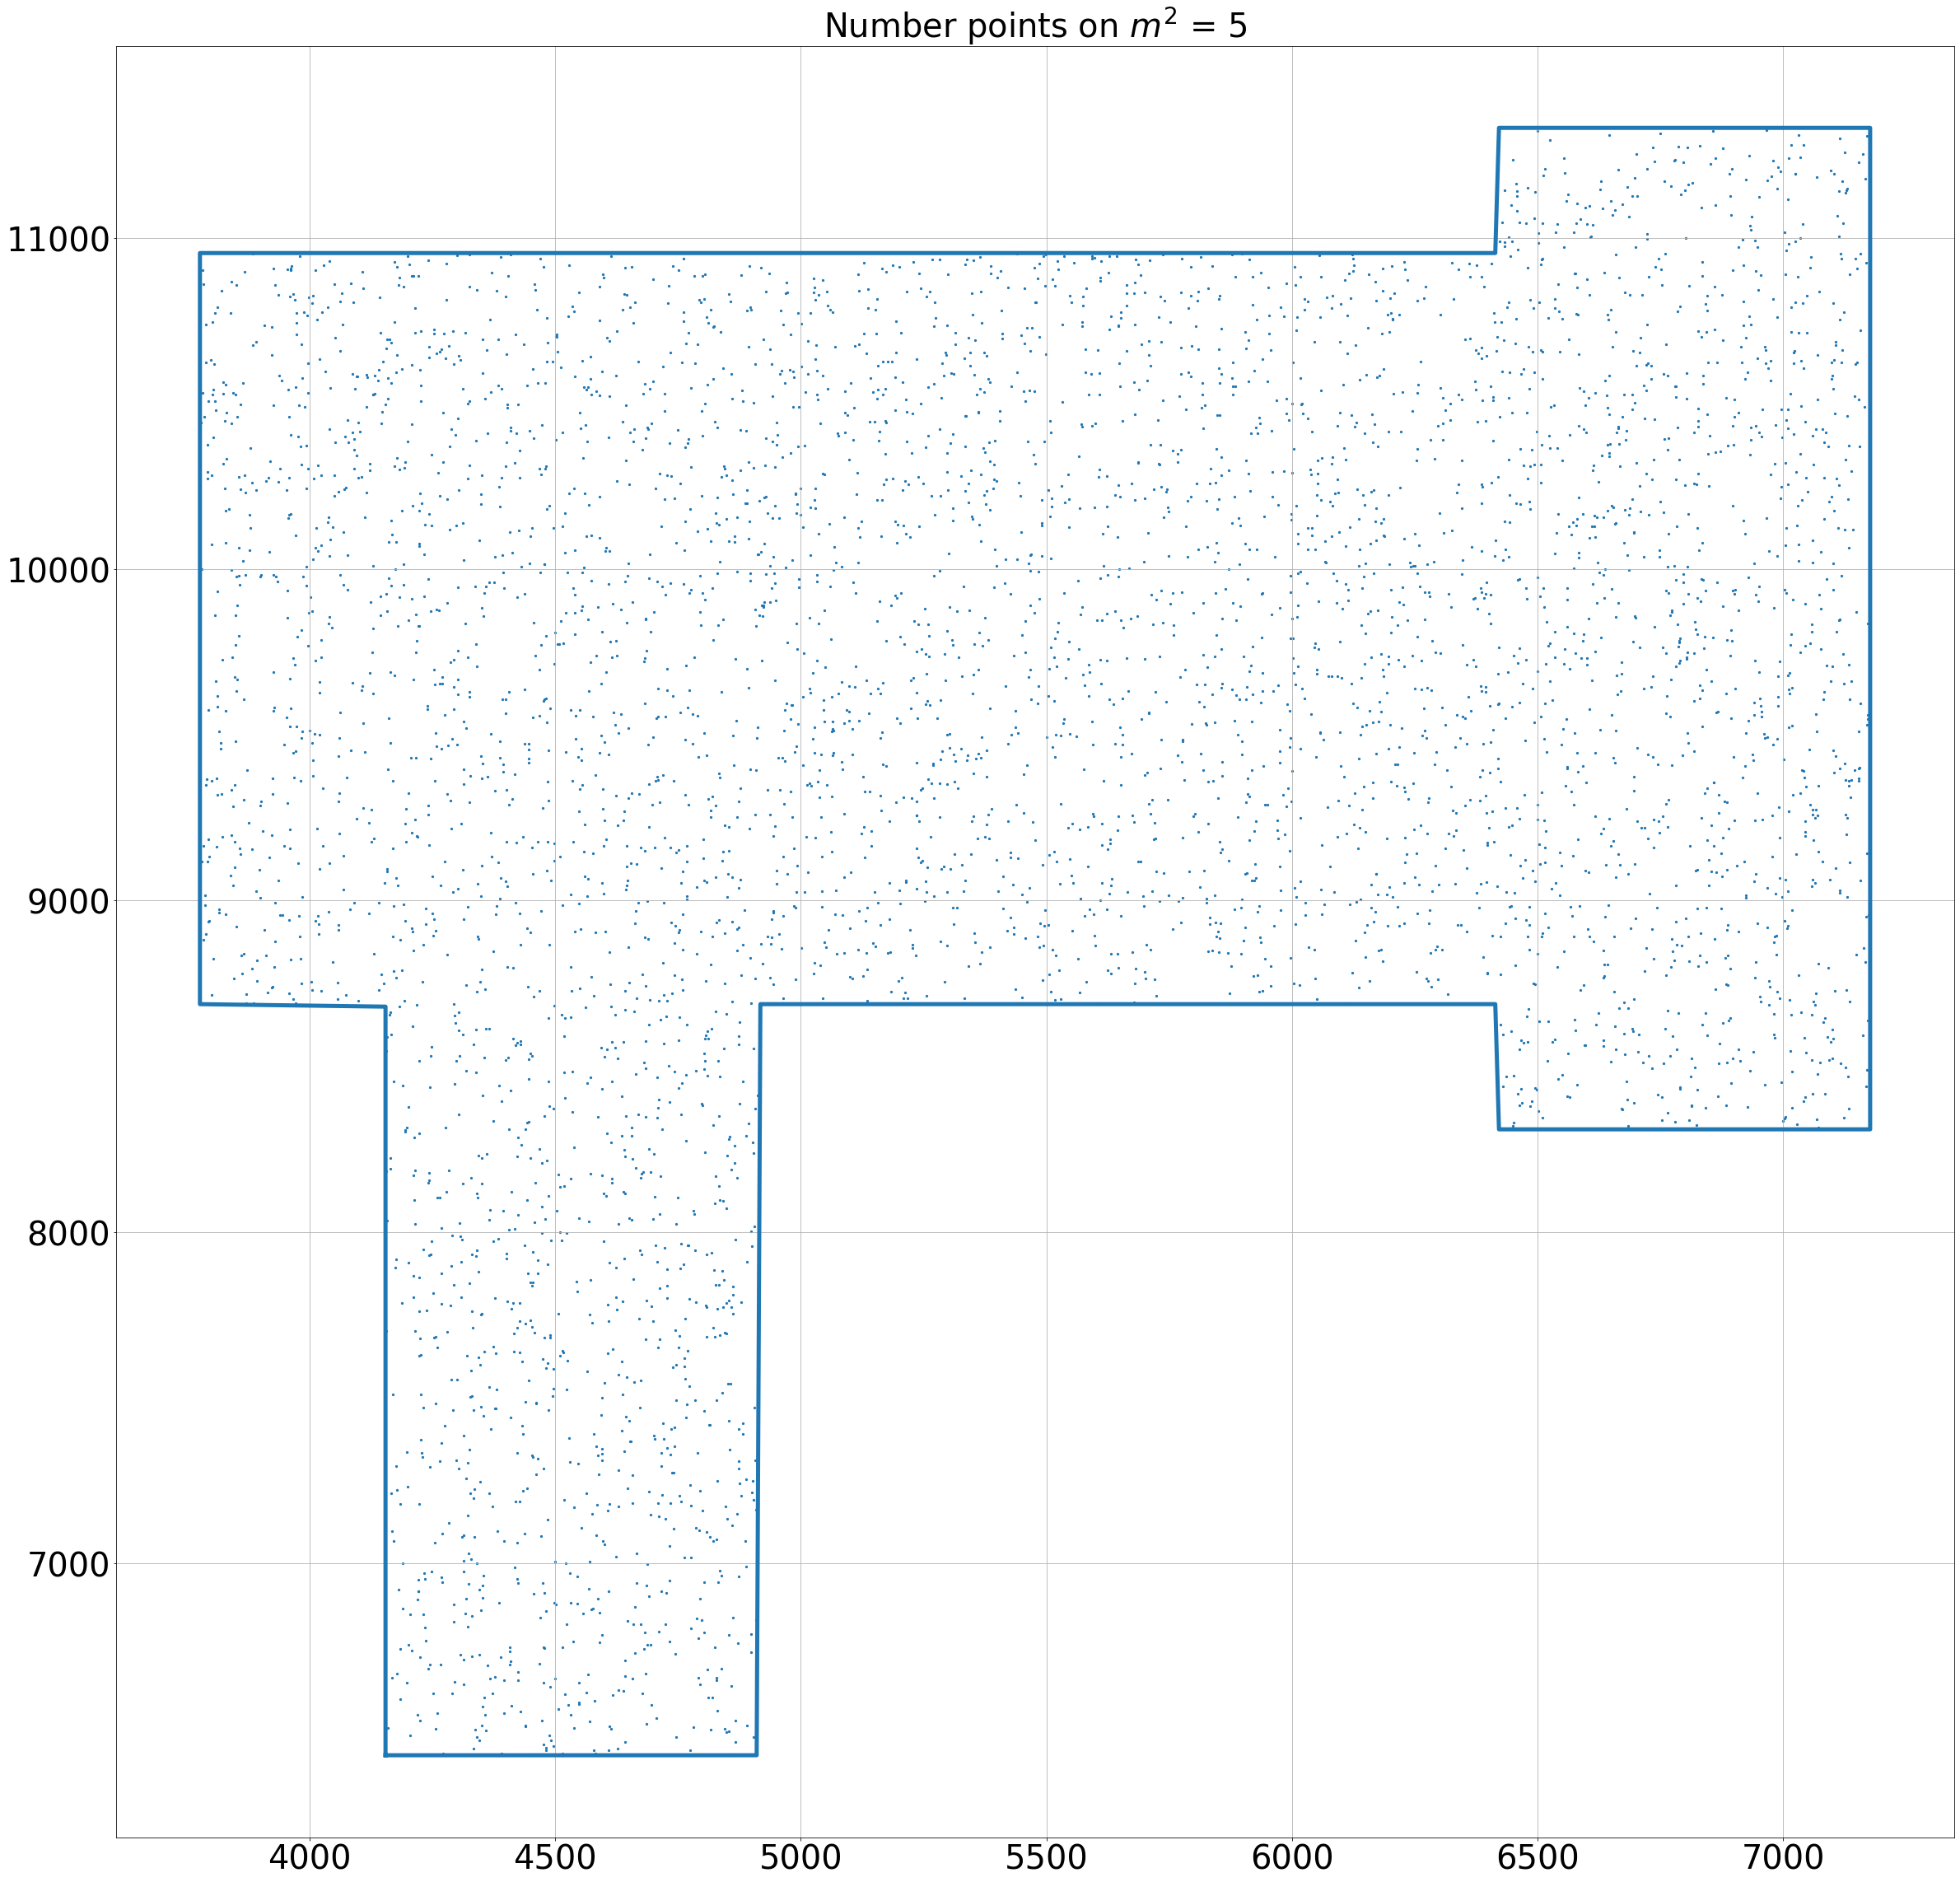

In [831]:
INNER_POINT_DENSITY = 5 # 5 - 10 points on m^2 (100px x 100px)

# poly.exterior.distance(point)
# polygon.area
# чем ближе к контуру, тем разброс меньше
def addNoiseInsidePolygon(poly_x, poly_y):
    polygon = Polygon([(p[0],p[1]) for p in zip(poly_x, poly_y)])
    polygonArea = polygon.area # in pix^2
    print('S(polygon)=', polygonArea, 'px')
    print('S(polygon)=', polygonArea / (meter2pixels**2), 'm2')
    n = int((polygonArea / (meter2pixels**2)) * INNER_POINT_DENSITY)
    print(n)
    xMin, xMax = np.min(polygon.exterior.xy[0]), np.max(polygon.exterior.xy[0])
    yMin, yMax = np.min(polygon.exterior.xy[1]), np.max(polygon.exterior.xy[1])
    
    innerNoise_x = []
    innerNoise_y = []
    for i in range(n):
        inside = False
        point = None
        while not inside:
            random_x = np.random.uniform(xMin, xMax)
            random_y = np.random.uniform(yMin, yMax)
            point = Point(random_x, random_y)
            inside = polygon.contains(point)
        innerNoise_x.append(point.x)
        innerNoise_y.append(point.y)
    return innerNoise_x, innerNoise_y

innerNoise_x, innerNoise_y = addNoiseInsidePolygon(poly_x, poly_y)


plt.figure(figsize=(40, 40))
plt.plot(poly_x, poly_y, linewidth=5)
plt.scatter(innerNoise_x, innerNoise_y, s=5)
plt.title('Number points on $m^2$ = ' + str(INNER_POINT_DENSITY), fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.show()

S(polygon)= 10000000.0 px
S(polygon)= 1000.0 m2
1000


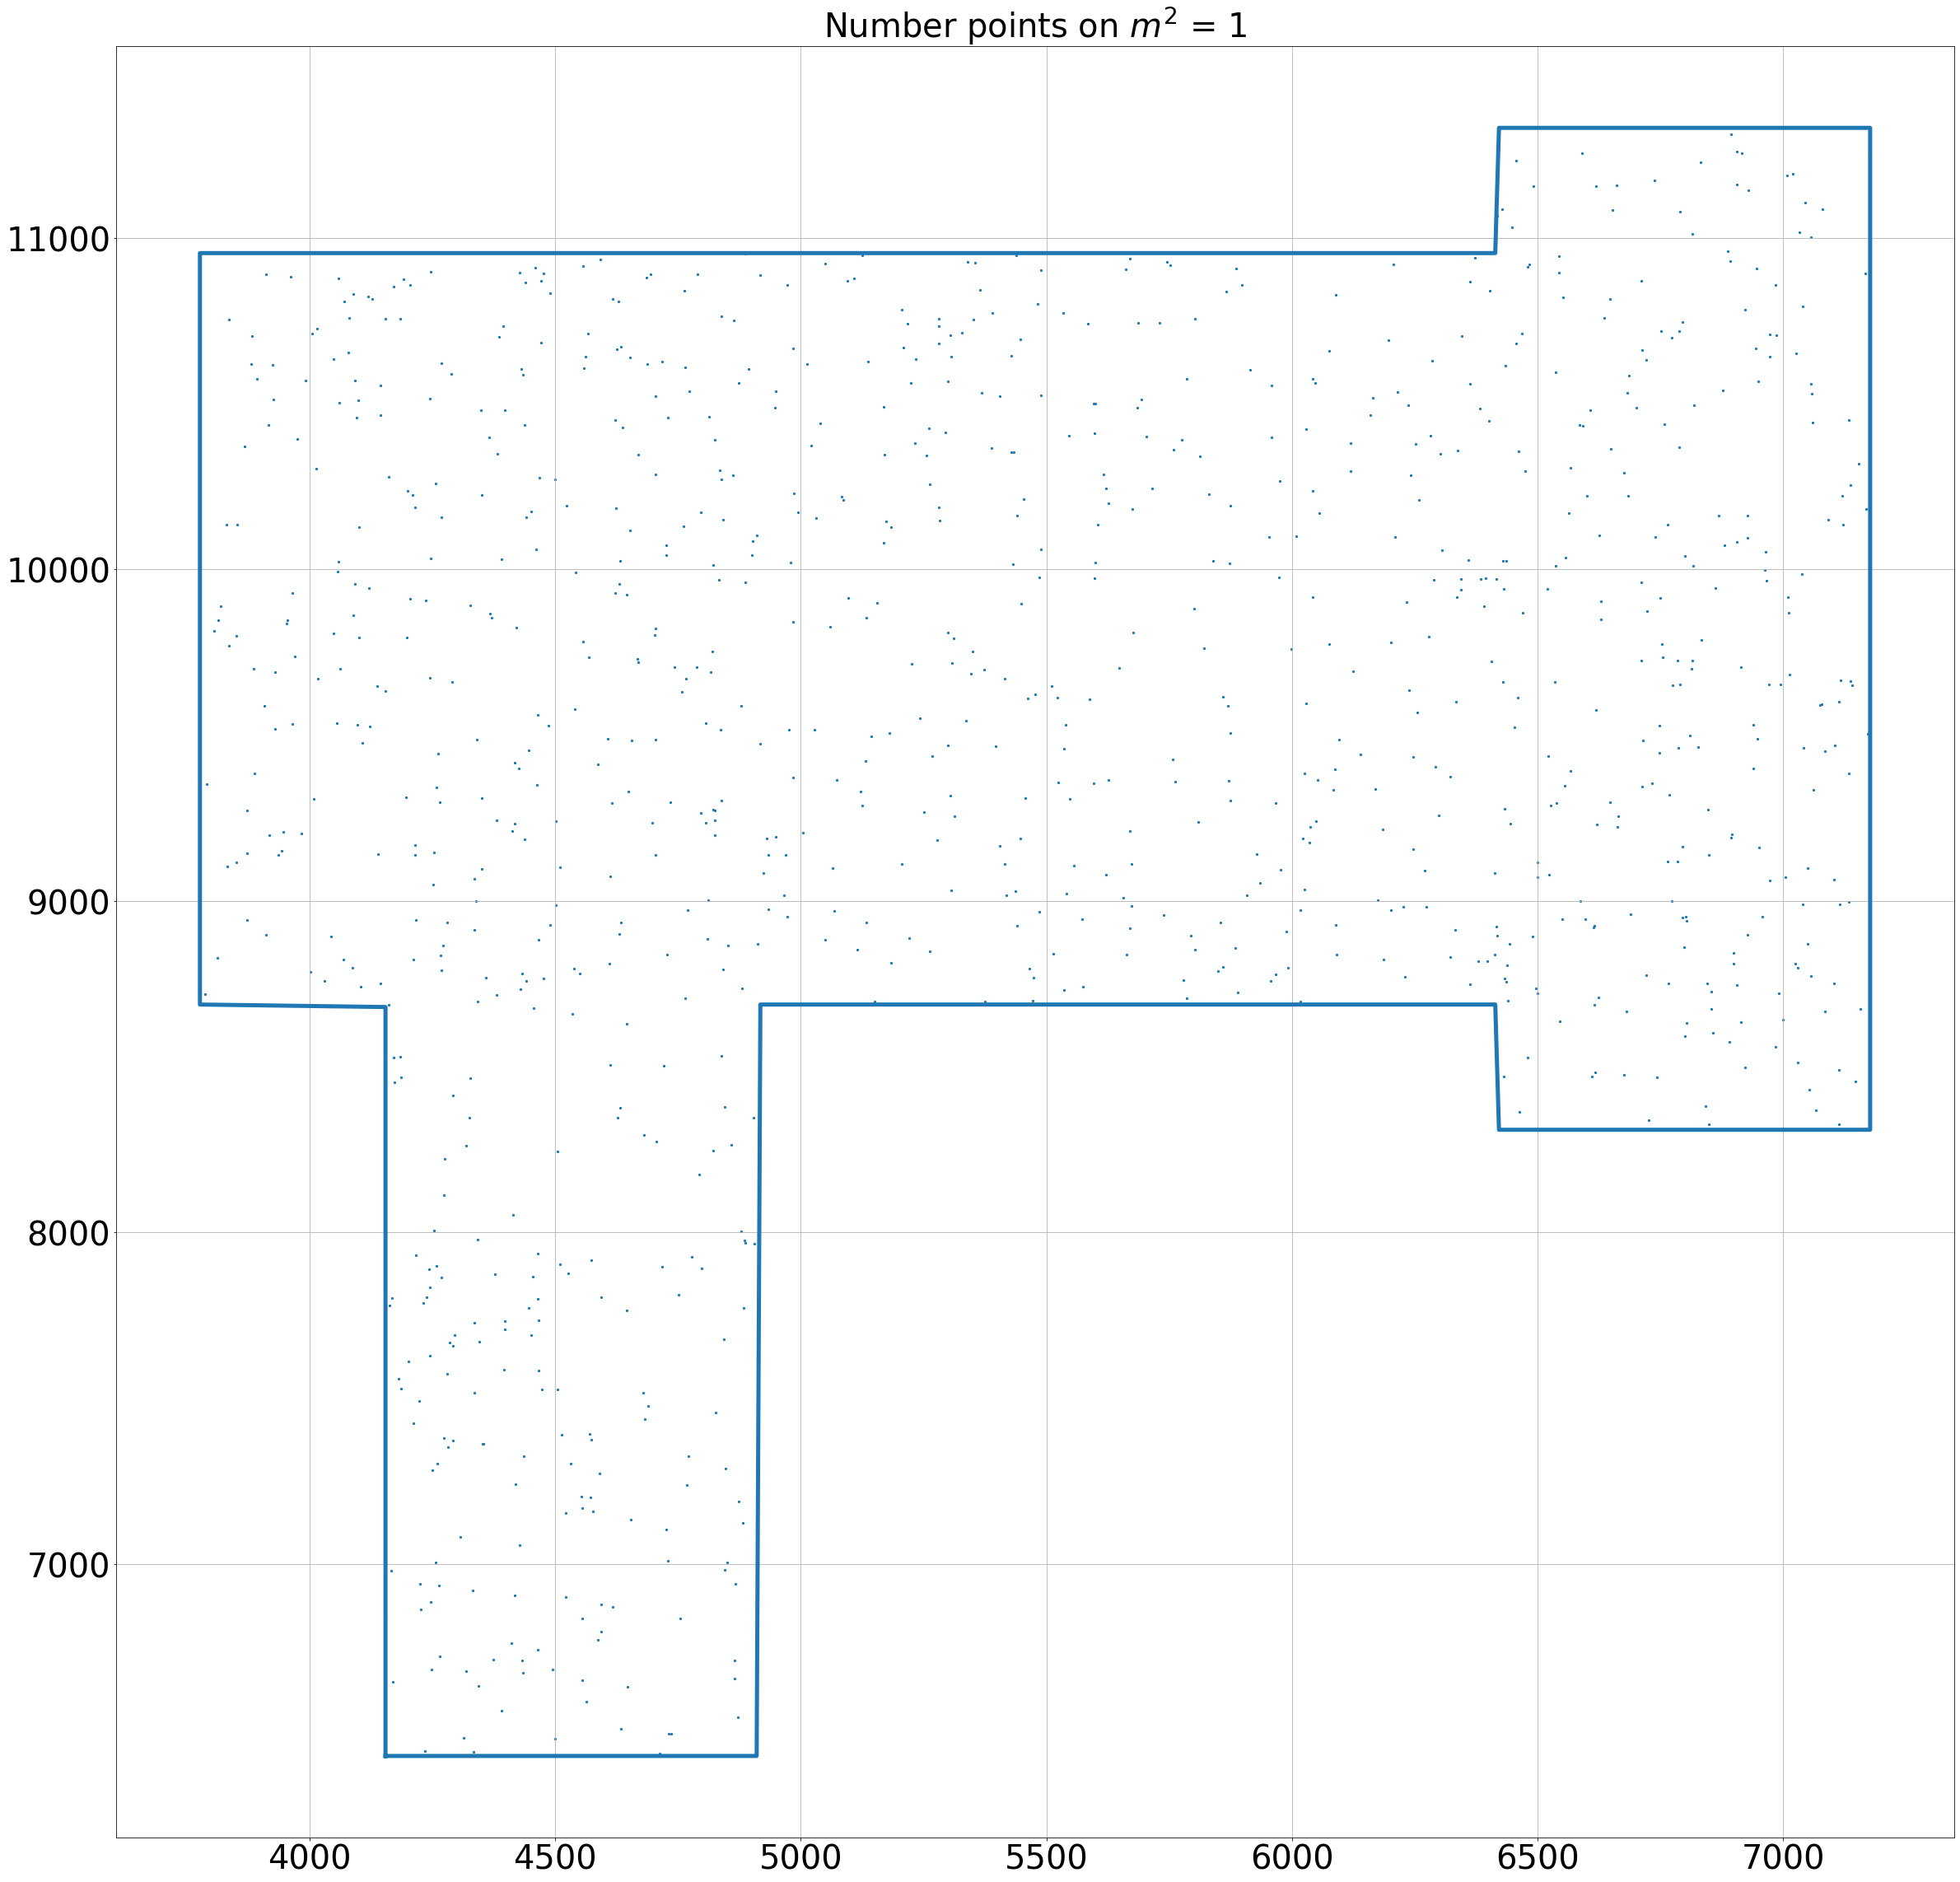

S(polygon)= 10000000.0 px
S(polygon)= 1000.0 m2
10000


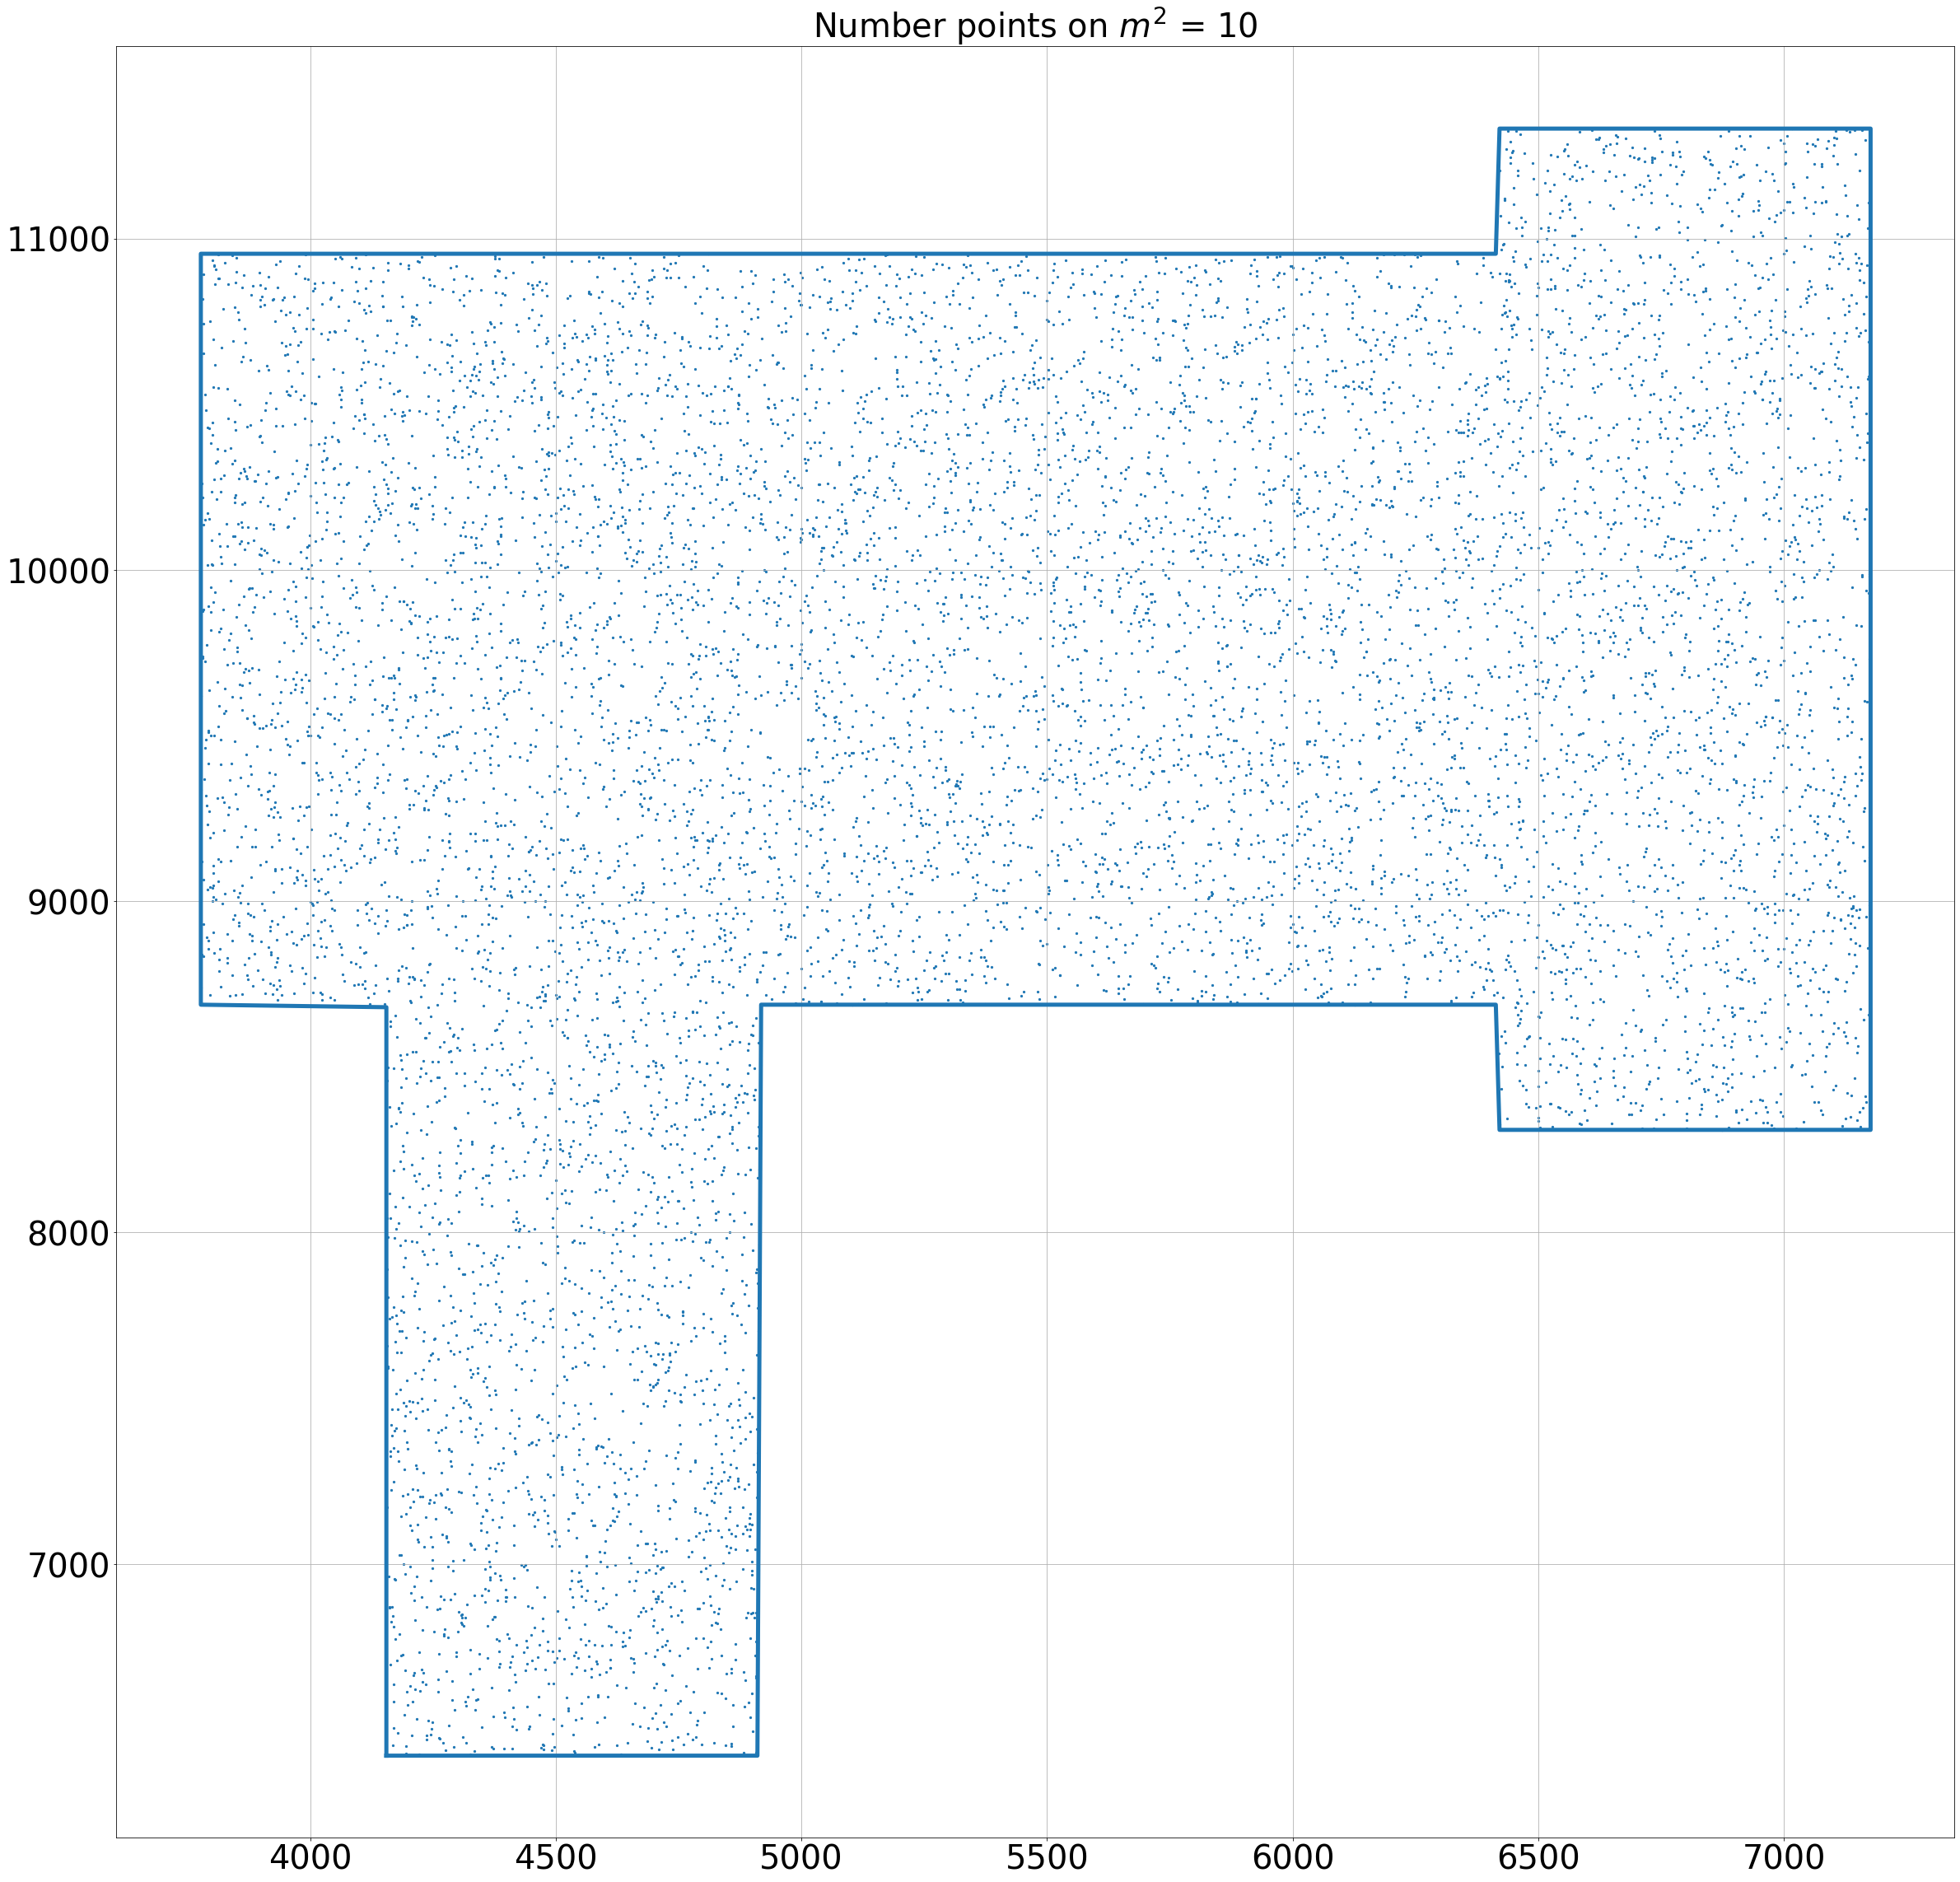